# <ins style = "color : orange" > Hawkes Process Analysis of Data Breaches. By LAITA Sami, BARAKA Rayane and KHOUTAIBI Illiass
  
This notebook performs an analysis of data breaches using a Hawkes process model. The goal is to model the times between successive data breach events and estimate the parameters of the Hawkes process that best describe the observed data.

The Hawkes process is a self-exciting point process, meaning that the occurrence of an event increases the probability of future events. This is particularly relevant for modeling data breaches, as one breach might trigger subsequent attacks or reveal vulnerabilities that lead to more breaches.

We will focus on estimating the parameters of the Hawkes process with an exponential decay kernel, given by the intensity function:

$$
\dot{y}(N,t)=\alpha+\beta\int_0^{t}e^{γ(t−s)} dN(s)$$

where:
- $\alpha$ is the background intensity of events.
- $\beta$ is the exciting factor, representing the average number of new events triggered by a previous event.
- $\gamma$ is the decay rate of the excitation effect.

In [3]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import expon, chisquare, chi2, kstest
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy import stats

### Loading the data

First of all, let us load the data of the PRC, which will be used further down to detemine the coefficients of the <strong>Hawks</strong> process.

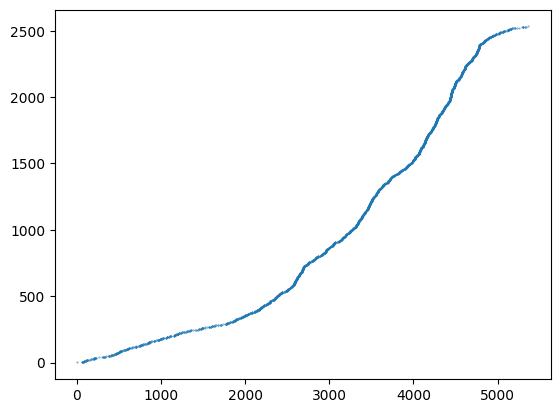

In [4]:
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
unique_l = np.unique(l)
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.show()

For a complete description of its content and of the motivations behind this analysis. We are going to make a simplified analysis by modeling time of attacks by a Hawkes process with intensity  

$$
\dot{y}(N,t)=\alpha+\beta\int_0^{t}e^{γ(t−s)} dN(s)$$


The log-likelihood function is defined as:

$$
\log L(N, t) = \sum_{T_n \leq t} \log \left(\alpha + \beta \sum_{j=1}^{n-1} e^{-\gamma\left(T_n-T_j\right)}\right) + (1-\alpha) t - \frac{\beta}{\gamma} \sum_{T_n \leq t} \left(1 - e^{-\gamma\left(t-T_n\right)}\right)
$$

In order to maximize the log-likelihood (minize the negative log-likelihood in this case). Scipy offers a <strong>minimization</strong> function, whcih takes in parameters the function to minimize, the constraints of said minimization and the initial coordinates of minimization.

The initial params are detrimental in the minimization. In the cell down below, we have decided to implement a function whcih helps us determine the best initial conditions for our optimization problem.

We first define our log-likelihhod function.


In [75]:
def neg_log_likelihood(params, time, eps = 1e-10):
    """
    function which returns the negative log-likelihood of the process given the parameters and the jump times
    arg:
        params: parameters of the model
        time: jump times
    return:
        negative log-likelihood (float)
    """

    # variables and parameters
    alpha, beta, gamma = params
    t = time[-1]

    # log-likelihood and integral term
    ll = 0.0
    S = 0.0

    # internal sum
    for tn in time[time <= t]:
        ll += np.log(alpha + beta * S + eps)
        S += np.sum(np.exp(-gamma * (tn - time[time < tn])))
    # right-hand term
    ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
    return -ll

def objective_function(params):
    return neg_log_likelihood(params, l)

In [52]:
constraints = [
          {'type': 'ineq', 'fun': lambda x: x[0]+1e-18},  # alpha > 0
          {'type': 'ineq', 'fun': lambda x: x[1]+1e-18},  # beta > 0
          {'type': 'ineq', 'fun': lambda x: x[2]+1e-18},
          {'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }]  # gamma > 0

In [19]:
#on définit la liste des temps d'arrivés uniques et le nombre d'arrivées pour chaque temps

l_uniques=[]
count_l=[]
for t in l:
    if t not in l_uniques:
        l_uniques.append(t)
        count_l.append(1)
    else:
        i=l_uniques.index(t)
        count_l[i]+=1


#on remarque qu'il y a des doublons
len(l_uniques)==len(l)

l_uniques_array = np.array(l_uniques)

Now we can begin out exploration. To make things easier, we will fix $\beta = 0.5$ and $\gamma = 1.0$. Our initial parameter exploration will go through $\alpha$.

Plotting the impact of Alpha on the log-likelihood function:


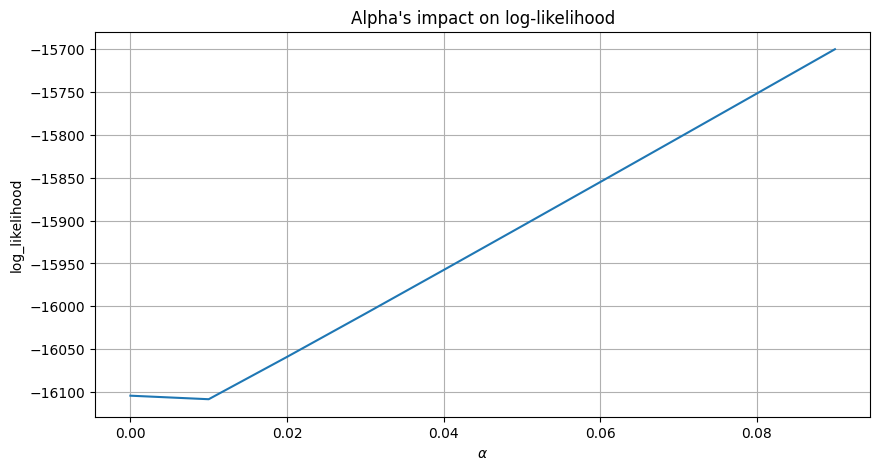

In [76]:
# Let's fix beta and gamma for this exploration
beta_fixed = 0.5
gamma_fixed = 1.0

# Exploting Alpha
print("Plotting the impact of Alpha on the log-likelihood function:")
alphas_explore = np.arange(0, 0.1, 0.01)
likelihood_alpha = []


try:
    for alpha_val in alphas_explore:
        log_like_val = -neg_log_likelihood([alpha_val, beta_fixed, gamma_fixed],l)
        likelihood_alpha.append(-log_like_val)

except ValueError:
   likelihood_alpha.append(np.nan)

likelihood_alpha = np.array(likelihood_alpha)

plt.figure(figsize=(10, 5))
plt.title("Alpha's impact on log-likelihood")
plt.plot(alphas_explore, likelihood_alpha)
plt.xlabel(r"$\alpha$")
plt.ylabel("log_likelihood")
plt.grid()
plt.show()

In [77]:
# Choose some values for beta and gamma to test
beta_values_to_test = [0.1, 0.5,  1.0, 2.0]
gamma_values_to_test = [0.5, 1.0, 2.0, 5.0]
alpha_fixed = 0.02

# Result of the minimization
results = {}

# Constraint of the minimization, as explained in the course.
constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
          {'type': 'ineq', 'fun': lambda x: x[0]+1e-18},  # alpha > 0
          {'type': 'ineq', 'fun': lambda x: x[1]+1e-18},  # beta > 0
          {'type': 'ineq', 'fun': lambda x: x[2]+1e-18}]  # gamma > 0

# Bounds of the minimization
bnds = ((0, None),(0, None),(0, 1))

In [54]:
def test(params):
  return neg_log_likelihood(params,l)

In [56]:
print("Looking for the best initialization params\n")

for beta_val in beta_values_to_test:

    for gamma_val in gamma_values_to_test:
        initial_params_test = [alpha_fixed, beta_val, gamma_val]
        print(f"Test with initial conditions: alpha={alpha_fixed}, beta={beta_val}, gamma={gamma_val}")

        try:

            res_test = minimize(test, initial_params_test, bounds=bnds, constraints=constr)

            results[f"beta={beta_val}, gamma={gamma_val}"] = {
                "success": res_test.success,
                "fun": res_test.fun, # minimal negative log-likelihood
                "x": res_test.x # optimal parameters found
            }

            print(f"Success: {res_test.success}, Negative log-likelihood: {res_test.fun:.4f}, Found params: {res_test.x}\n")

        except Exception as e:

            print(f"  Error during the optimisation :  {e}")
            results[f"beta={beta_val}, gamma={gamma_val}"] = {
                "success": False,
                "error": str(e)
            }

Looking for the best initialization params

Test with initial conditions: alpha=0.4728, beta=0.1, gamma=0.5


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039668 0.05683516 0.05684843]

Test with initial conditions: alpha=0.4728, beta=0.1, gamma=1.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide

Success: True, Negative log-likelihood: -17425.8760, Found params: [0.06461642 0.09636676 0.13653663]

Test with initial conditions: alpha=0.4728, beta=0.1, gamma=2.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039692 0.05683306 0.05684669]

Test with initial conditions: alpha=0.4728, beta=0.1, gamma=5.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039672 0.05683518 0.05684844]

Test with initial conditions: alpha=0.4728, beta=0.5, gamma=0.5


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: 621.9167, Found params: [4.69486780e-01 2.35717856e+06 3.84134670e+06]

Test with initial conditions: alpha=0.4728, beta=0.5, gamma=1.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039693 0.05683535 0.05684865]

Test with initial conditions: alpha=0.4728, beta=0.5, gamma=2.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -931.2264, Found params: [4.72036076e-01 2.09012578e-10 3.93756511e+01]

Test with initial conditions: alpha=0.4728, beta=0.5, gamma=5.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039684 0.05683505 0.05684828]

Test with initial conditions: alpha=0.4728, beta=1.0, gamma=0.5


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -931.2264, Found params: [4.72035512e-01 1.05544005e-18 6.48717824e+02]

Test with initial conditions: alpha=0.4728, beta=1.0, gamma=1.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  co

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039657 0.05683533 0.05684942]

Test with initial conditions: alpha=0.4728, beta=1.0, gamma=2.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039689 0.05683499 0.05684824]

Test with initial conditions: alpha=0.4728, beta=1.0, gamma=5.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -17960.6424, Found params: [0.00039671 0.05683487 0.05684806]

Test with initial conditions: alpha=0.4728, beta=2.0, gamma=0.5
Success: True, Negative log-likelihood: -931.2264, Found params: [ 0.47203581  0.         12.72700685]

Test with initial conditions: alpha=0.4728, beta=2.0, gamma=1.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide

Success: False, Negative log-likelihood: -17387.3331, Found params: [0.00456466 0.47808016 0.46929615]

Test with initial conditions: alpha=0.4728, beta=2.0, gamma=2.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: invalid value encountered in scalar divide
  co

Success: True, Negative log-likelihood: -16791.0058, Found params: [0.1146319  0.48484771 0.48484697]

Test with initial conditions: alpha=0.4728, beta=2.0, gamma=5.0


/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  constr = [{'type': 'ineq', 'fun': lambda x: 1-x[1]/x[2] }, # beta/gamma < 1
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-51-2109664919.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
/tmp/ipython-input-12-155223880.py:10: RuntimeWarning: divide by zero encountered in scal

Success: True, Negative log-likelihood: -931.2264, Found params: [4.72032194e-01 2.90562224e-10 1.34663228e+02]



In [60]:
# Result Analysis
print("Exploration results summary:\n")

best_likelihood = np.inf
best_initial_params = None

for key, value in results.items():
    if value.get("success", False):

        print(f"Initiales ({key}): Negative log-likelihood = {value['fun']:.4f}, Optimal params = {value['x']}")

        if value['fun'] < best_likelihood:

            best_likelihood = value['fun']
            # Save the best params found
            best_params = value['x']

print("\n")
if best_params is not None:

    print(f"The optimized params with the best negative log likelihood are : {best_params}\n")

else:
    print("No optimisation converged.\n")

Exploration results summary:

Initiales (beta=0.1, gamma=0.5): Negative log-likelihood = -17960.6424, Optimal params = [0.00039668 0.05683516 0.05684843]
Initiales (beta=0.1, gamma=1.0): Negative log-likelihood = -17425.8760, Optimal params = [0.06461642 0.09636676 0.13653663]
Initiales (beta=0.1, gamma=2.0): Negative log-likelihood = -17960.6424, Optimal params = [0.00039692 0.05683306 0.05684669]
Initiales (beta=0.1, gamma=5.0): Negative log-likelihood = -17960.6424, Optimal params = [0.00039672 0.05683518 0.05684844]
Initiales (beta=0.5, gamma=0.5): Negative log-likelihood = 621.9167, Optimal params = [4.69486780e-01 2.35717856e+06 3.84134670e+06]
Initiales (beta=0.5, gamma=1.0): Negative log-likelihood = -17960.6424, Optimal params = [0.00039693 0.05683535 0.05684865]
Initiales (beta=0.5, gamma=2.0): Negative log-likelihood = -931.2264, Optimal params = [4.72036076e-01 2.09012578e-10 3.93756511e+01]
Initiales (beta=0.5, gamma=5.0): Negative log-likelihood = -17960.6424, Optimal par

In [61]:
alpha,beta,gamma = best_params

**Optimal parameters**

In [62]:
print("Optimal Alpha = ", alpha)
print("Optimal Beta = ", beta)
print("Optimal Gamma = ", gamma)

Optimal Alpha =  0.00039670751615376035
Optimal Beta =  0.05683486647232818
Optimal Gamma =  0.05684806425479374


We will compute $y(N, t)$ using the following formula found exercise 3.4.2.

$$y(N,t)=\alpha t + \frac{\beta}{\gamma} \sum_{T_n\leq t} (1-e^{-\gamma (t-T_n)})$$

In [63]:


def y_T(T,q,alpha,beta,gamma):
    mask = T < T[q]
    T_masked=T[mask]
    exps=1-np.exp(-gamma*(T[q]-T_masked))
    term1= ( beta / gamma )*exps.sum()
    term2 = alpha*T[q]
    return term1+term2



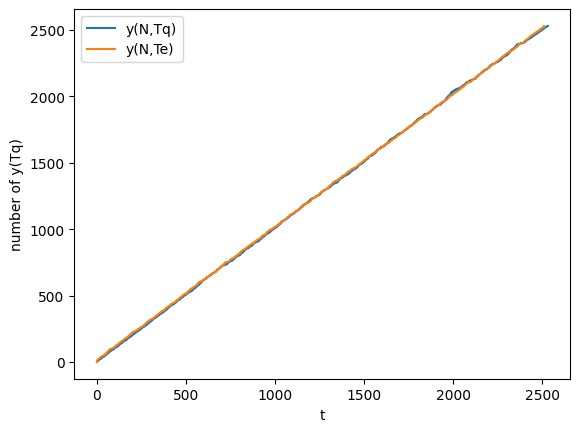

In [72]:
t_values = [y_T(l,q,alpha,beta,gamma) for q in range(len(l_adapted))]
jumps_poisson = np.cumsum(np.random.exponential(scale = 1, size = len(l_adapted)))
te_values = [y_T(jumps_poisson,q,alpha,beta,gamma) for q in range(len(l_adapted))]
integers=np.arange(0,len(t_values))


plt.plot(t_values, integers, label='y(N,Tq)')
plt.plot(te_values, integers, label='y(N,Te)') # temps d'arrivés théoriques exp(1)
plt.xlabel('t')
plt.ylabel("number of y(Tq)")
plt.legend()
plt.show()

Now that we have computed y, let's compare the distribution of inter-arrival times with generated poisson process .
To do so, we will compare the empirical histogram with the exponential densities

**Compare the mean**

In [66]:
inter_intervals = np.diff(t_values) # Inter arrivals
mean = np.mean(inter_intervals)
print("Sample mean of our distribution is:", mean)

Sample mean of our distribution is: 1.0003943034045093


**Data distribution**

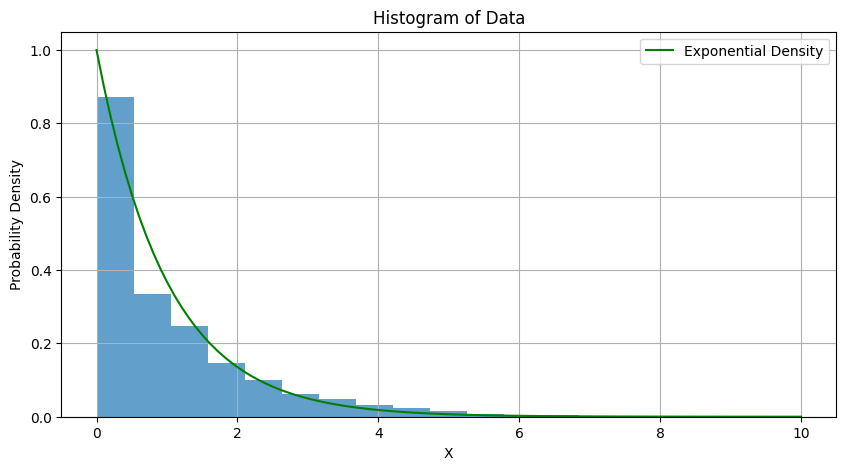

In [ ]:
plt.figure(figsize=(10, 5))
bins = np.linspace(0, 10 , 20)
plt.hist(inter_intervals, bins=bins, density=True, alpha=0.7)
plt.xlabel('X')
plt.grid()
plt.ylabel('Probability Density')
plt.title('Histogram of Data')

# Adding the theorical density plot
x_values = np.linspace(0, 10, 100)

# Exponential density with scale=1
density = stats.expon.pdf(x_values, scale=1)
plt.plot(x_values, density, 'g-', label='Exponential Density')
plt.legend()

plt.show()

The histogram of the data $(y(N, T_q(N)), n \geq 1)$ closely matches the exponential density function, indicating that the distribution of the data is close to the law of a Poisson process with intensity $1$. It is no wonder that the mean is also close to $1$.


**Kolmogorov-Smirnov test**

In [70]:
# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(t_values, te_values)

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {p_value}")

KS Statistic: 0.009873617693522907
P-Value: 0.9996768685246947


**Conclusion :** from the results obtained above, it looks like the generated process of intensity $y(N, t)$ is a Poisson process of intensity  1. This is what we were looking for when conducting the likelihood maximization.